<a href="https://colab.research.google.com/github/dydwofksl/Kalman_Filter/blob/master/UAM_tracking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import norm

In [2]:
Hz = 100.0 # 비전 시스템의 진동수
dt = 1.0/Hz
T = 1.0 # s 측정 시간
m = int(T/dt) # 측정 수

px= 0.0 # x 시작점
py= 0.0 # y 시작점
pz= 0.0 # z 시작점

vx = 0.0 # m/s 처음 속도
vy = 0.0 # m/s 처음 속도
vz = 5.0 # m/s 처음 속도

Xr=[]
Yr=[]
Zr=[]
for i in range(int(m)):
    accx = 0  # 항력
    
    vx += accx*dt
    px += vx*dt

    accz = 0 # 중력 + 저항
    vz += accz*dt
    pz += vz*dt
    
    if pz<0.01:
        vz=-vz*d
        pz+=0.02
    if vx<0.1:
        accx=0.0
        accz=0.0
        
    Xr.append(px)
    Yr.append(py)
    Zr.append(pz)


In [3]:
sp= 0.1 # 위치 노이즈에 대한 시그마

Xm = Xr + sp * (np.random.randn(m))
Ym = Yr + sp * (np.random.randn(m))
Zm = Zr + sp * (np.random.randn(m))

(0.7756050315509448, 4.257598809722041)

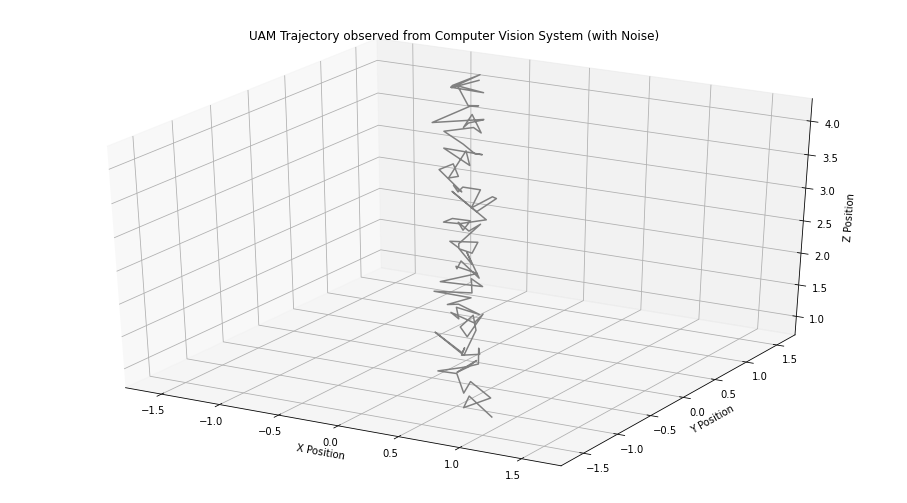

In [4]:
fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot(111, projection='3d') # 3d 형상
ax.plot(Xm, Ym, Zm, c='gray')
ax.set_xlabel('X Position') # x축 표기
ax.set_ylabel('Y Position') # y축 표기
ax.set_zlabel('Z Position') # z축 표기
plt.title('UAM Trajectory observed from Computer Vision System (with Noise)') #그래프 제목

#ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))

# 정사각형을 위한 동일 축
max_range = np.array([Xm.max()-Xm.min(), Ym.max()-Ym.min(), Zm.max()-Zm.min()]).max() / 3.0
mean_x = Xm.mean()
mean_y = Ym.mean()
mean_z = Zm.mean()
ax.set_xlim(mean_x - max_range, mean_x + max_range)
ax.set_ylim(mean_y - max_range, mean_y + max_range)
ax.set_zlim(mean_z - max_range, mean_z + max_range)

In [5]:
# Plotting을 위한 리스트
xt = []
yt = []
zt = []
dxt= []
dyt= []
dzt= []
ddxt=[]
ddyt=[]
ddzt=[]
Zx = []
Zy = []
Zz = []
Px = []
Py = []
Pz = []
Pdx= []
Pdy= []
Pdz= []
Pddx=[]
Pddy=[]
Pddz=[]
Kx = []
Ky = []
Kz = []
Kdx= []
Kdy= []
Kdz= []
Kddx=[]
Kddy=[]
Kddz=[]

In [6]:
# Plotting을 위한 리스트2
xt2 = []
yt2 = []
zt2 = []
xt3 = []
yt3 = []
zt3 = []
dxt2= []
dyt2= []
dzt2= []
ddxt2=[]
ddyt2=[]
ddzt2=[]
Zx2 = []
Zy2 = []
Zz2 = []
Px2 = []
Py2 = []
Pz2 = []
Pdx2= []
Pdy2= []
Pdz2= []
Pddx2=[]
Pddy2=[]
Pddz2=[]
Kx2 = []
Ky2 = []
Kz2 = []
Kdx2= []
Kdy2= []
Kdz2= []
Kddx2=[]
Kddy2=[]
Kddz2=[]

In [7]:
# 이전 추정값을 통해 추정값을 예측할 때 사용하는 행렬

dt = 0.01 # Time Step between Filter Steps

A = np.matrix([[1.0, 0.0, 0.0, dt, 0.0, 0.0, 1/2.0*dt**2, 0.0, 0.0],
              [0.0, 1.0, 0.0, 0.0,  dt, 0.0, 0.0, 1/2.0*dt**2, 0.0],
              [0.0, 0.0, 1.0, 0.0, 0.0,  dt, 0.0, 0.0, 1/2.0*dt**2],
              [0.0, 0.0, 0.0, 1.0, 0.0, 0.0,  dt, 0.0, 0.0],
              [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0,  dt, 0.0],
              [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0,  dt],
              [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0],
              [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0],
              [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]])

In [8]:
# 추정값을 측정값의 형태로 변환할 때 필요한 행렬

H = np.matrix([[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
               [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
               [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]])

In [9]:
# 초기 상태변수

x = np.matrix([0.0, 0.0, 1.0, 10.0, 0.0, 0.0, 0.0, 0.0, -9.81]).T

In [10]:
# 교란 제어 행렬

B = np.matrix([[0.0],
               [0.0],
               [0.0],
               [0.0],
               [0.0],
               [0.0],
               [0.0],
               [0.0],
               [0.0]])

In [11]:
# 시스템 노이즈

sj = 0.1

Q = np.matrix([[(dt**6)/36, 0, 0, (dt**5)/12, 0, 0, (dt**4)/6, 0, 0],
               [0, (dt**6)/36, 0, 0, (dt**5)/12, 0, 0, (dt**4)/6, 0],
               [0, 0, (dt**6)/36, 0, 0, (dt**5)/12, 0, 0, (dt**4)/6],
               [(dt**5)/12, 0, 0, (dt**4)/4, 0, 0, (dt**3)/2, 0, 0],
               [0, (dt**5)/12, 0, 0, (dt**4)/4, 0, 0, (dt**3)/2, 0],
               [0, 0, (dt**5)/12, 0, 0, (dt**4)/4, 0, 0, (dt**3)/2],
               [(dt**4)/6, 0, 0, (dt**3)/2, 0, 0, (dt**2), 0, 0],
               [0, (dt**4)/6, 0, 0, (dt**3)/2, 0, 0, (dt**2), 0],
               [0, 0, (dt**4)/6, 0, 0, (dt**3)/2, 0, 0, (dt**2)]]) *sj**2

In [12]:
# Control input

u = 0.0

In [13]:
# Identity Matrix

I = np.eye(9)

In [14]:
# 측정값 노이즈

rp = 1.0**2  # Noise of Position Measurement
R = np.matrix([[rp, 0.0, 0.0],
               [0.0, rp, 0.0],
               [0.0, 0.0, rp]])

In [16]:
# 오차 공분산

P = 100.0*np.eye(9)

In [17]:
measurements = np.vstack((Xm,Ym,Zm))

In [18]:
hitplate=False
for filterstep in range(m):
    
    # Model the direction switch, when hitting the plate
    if x[2]<0.01 and not hitplate:
        x[5]=-x[5]
        hitplate=True
    
    # Time Update (Prediction)
    # ========================
    # 현재 상태변수 예측
    x = A*x + B*u
    
    # 오차 공분산 예측
    P = A*P*A.T + Q    
    
    
    # Measurement Update (Correction)
    # ===============================
    # 칼만 이득 계산
    S = H*P*H.T + R
    K = (P*H.T) * np.linalg.pinv(S)

    
    # 보정된 상태변수 갱신
    Z = measurements[:,filterstep].reshape(H.shape[0],1)
    y = Z - (H*x)                            # Innovation or Residual
    x = x + (K*y)
    
    # 보정된 오차 공분산 갱신
    P = (I - (K*H))*P
    
   
    
    # Plotting을 위한 상태변수 값 저장
    xt.append(float(x[0]))
    yt.append(float(x[1]))
    zt.append(float(x[2]))
    dxt.append(float(x[3]))
    dyt.append(float(x[4]))
    dzt.append(float(x[5]))
    ddxt.append(float(x[6]))
    ddyt.append(float(x[7]))
    ddzt.append(float(x[8]))
    
    Zx.append(float(Z[0]))
    Zy.append(float(Z[1]))
    Zz.append(float(Z[2]))
    Px.append(float(P[0,0]))
    Py.append(float(P[1,1]))
    Pz.append(float(P[2,2]))
    Pdx.append(float(P[3,3]))
    Pdy.append(float(P[4,4]))
    Pdz.append(float(P[5,5]))
    Pddx.append(float(P[6,6]))
    Pddy.append(float(P[7,7]))
    Pddz.append(float(P[8,8]))
    Kx.append(float(K[0,0]))
    Ky.append(float(K[1,0]))
    Kz.append(float(K[2,0]))
    Kdx.append(float(K[3,0]))
    Kdy.append(float(K[4,0]))
    Kdz.append(float(K[5,0]))
    Kddx.append(float(K[6,0]))
    Kddy.append(float(K[7,0]))
    Kddz.append(float(K[8,0]))

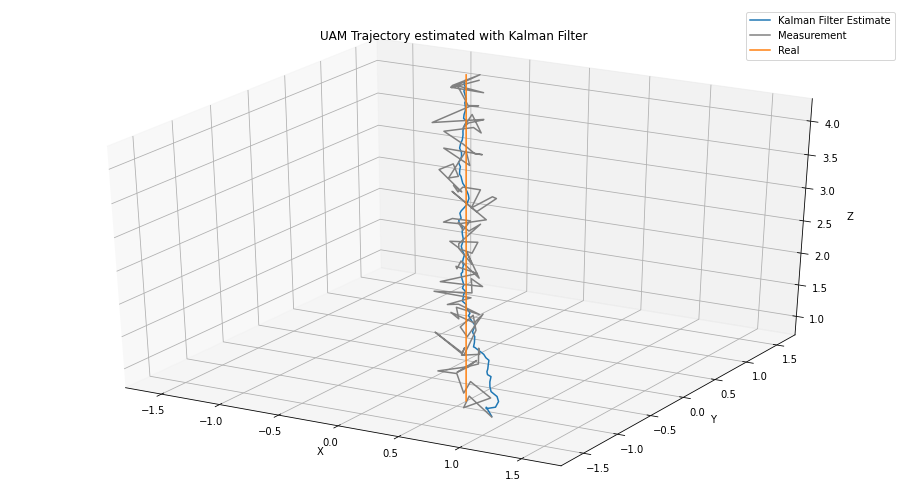

In [19]:
fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot(111, projection='3d')
ax.plot(xt,yt,zt, label='Kalman Filter Estimate')
ax.plot(Xm,Ym, Zm, label='Measurement', c='gray', )
ax.plot(Xr, Yr, Zr, label='Real')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.legend()
plt.title('UAM Trajectory estimated with Kalman Filter')

# Axis equal
max_range = np.array([Xm.max()-Xm.min(), Ym.max()-Ym.min(), Zm.max()-Zm.min()]).max() / 3.0
mean_x = Xm.mean()
mean_y = Ym.mean()
mean_z = Zm.mean()
ax.set_xlim(mean_x - max_range, mean_x + max_range)
ax.set_ylim(mean_y - max_range, mean_y + max_range)
ax.set_zlim(mean_z - max_range, mean_z + max_range)
plt.savefig('Kalman-Filter-CA-Ball-Trajectory.png', dpi=150, bbox_inches='tight')